# Health Risk Classification
**Project:** Lab #07 — Open-Ended Lab  
**Project Name:** Health Risk Classification  
**Roll No:** 22F-BSAI-42  
**Objective:** Predict the likelihood of diabetes in patients using the Pima Indians Diabetes dataset.


Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib


Load data & quick EDA

(768, 9)
Outcome
0    500
1    268
Name: count, dtype: int64


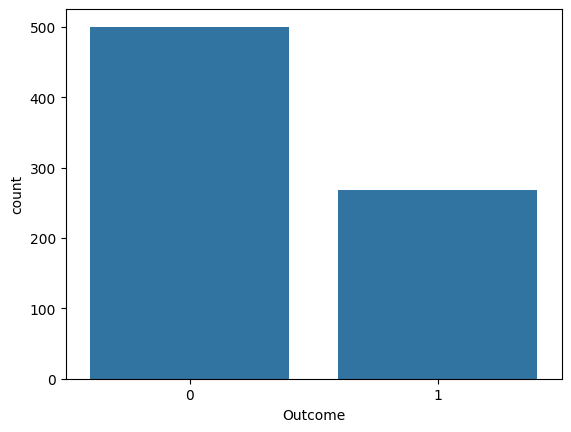

In [4]:
df = pd.read_csv('diabetes.csv')  # update path if needed
print(df.shape)
df.head()
print(df['Outcome'].value_counts())  # 1 = diabetes, 0 = no diabetes
sns.countplot(x='Outcome', data=df)
plt.show()


Handle zero-values as missing (domain-specific)

In [5]:
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_with_zeros:
    df[c] = df[c].replace(0, np.nan)

print(df[cols_with_zeros].isnull().sum())


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Split data

In [ ]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Preprocessing and SMOTE

In [ ]:
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Fit-transform training data, then apply SMOTE to balance classes
from sklearn.pipeline import make_pipeline
pipeline_prep = Pipeline(steps=[('num', numeric_transformer)])
X_train_proc = pipeline_prep.fit_transform(X_train)
X_test_proc = pipeline_prep.transform(X_test)

# SMOTE to handle imbalance (optional but recommended)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)
print("Resampled class distribution:\n", pd.Series(y_train_res).value_counts())


Resampled class distribution:
 Outcome
0    400
1    400
Name: count, dtype: int64


Model 1: SVM

In [ ]:
svc = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svc.fit(X_train_res, y_train_res)
y_pred_svc = svc.predict(X_test_proc)

print("SVM accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
print("SVM ROC-AUC:", roc_auc_score(y_test, svc.predict_proba(X_test_proc)[:,1]))


SVM accuracy: 0.7272727272727273
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       100
           1       0.60      0.69      0.64        54

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154

SVM ROC-AUC: 0.8112037037037038


Model 2: Decision Tree

In [ ]:
# Block B7: Decision Tree
dt = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test_proc)

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("Decision Tree ROC-AUC:", roc_auc_score(y_test, dt.predict_proba(X_test_proc)[:,1]))


Decision Tree accuracy: 0.7142857142857143
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.58      0.67      0.62        54

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.73      0.71      0.72       154

Decision Tree ROC-AUC: 0.7253703703703704


Confusion matrices

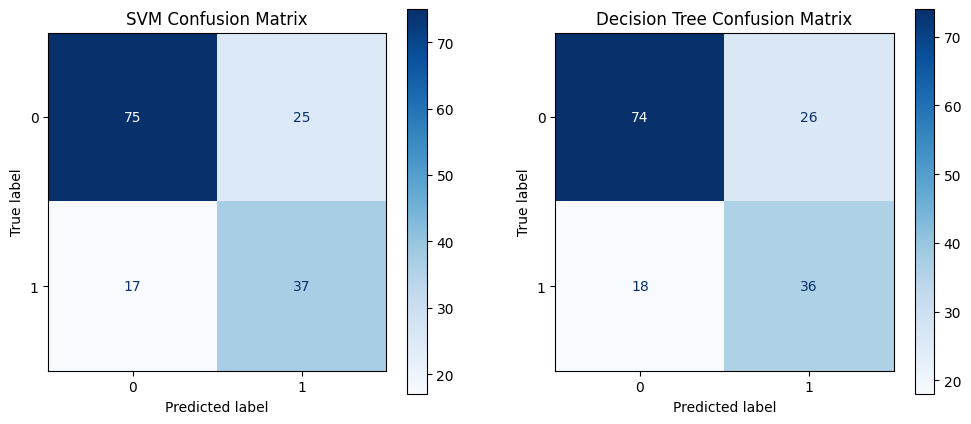

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1,2, figsize=(12,5))
ConfusionMatrixDisplay.from_estimator(svc, X_test_proc, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('SVM Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(dt, X_test_proc, y_test, ax=axes[1], cmap='Blues')
axes[1].set_title('Decision Tree Confusion Matrix')
plt.show()
